1.1 TSP

In [ ]:
%matplotlib nbagg
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn
from matplotlib.animation import FuncAnimation
from random import random
import random
import os

At first we generate points

In [3]:
def circle_random(count, d=2):
    r=np.random.uniform(size=count)
    r=np.array(list(zip(r,r))) 
    vecs=np.random.uniform(size=(count,d))
    mag=np.sqrt(np.sum(np.square(vecs),axis=1))
    mag=np.array(list(zip(mag,mag)))
    return r*vecs/mag
def gen_points(n,pattern):
    if pattern=='uniform':
        return np.random.rand(2,n).T
    if pattern=='cities':
        #nine separated groups
        cities_cords=[(0,0),(0,10),(0,20),(10,0),(10,10),(10,20),(20,0),(20,10),(20,20)]
        res=np.empty((0,2))
#         print(res.shape)
        for x,y in cities_cords:
            verts=circle_random(n//9)
            verts+=(x,y)
            res=np.concatenate((res,verts),axis=0)
        return res
    if pattern=='normal':
        cities_cords=[(0,0),(0,10),(10,0),(10,10)]
        res=np.empty((0,2))
        print(res.shape)
        for x,y in cities_cords:
            A = np.random.rand(2, 2)
            A[0,0]*=0.3
            A[1,1]*=0.8
            A[0,1]*=1.
            A[1,0]*=1.5
            cov_matrix = np.dot(A, A.T)
            rv = mvn([x, y],cov_matrix )
            res=np.concatenate((res,rv.rvs(size=n//len(cities_cords), random_state=12345)),axis=0)
        return res

Then simmulated annealing is implemented

In [125]:
def cost(coords):
    """calc cost of state coords"""
    res=0
    for i in range(len(coords)):
        res+=np.square(coords[i-1][0]-coords[i][0])+np.square(coords[i-1][1]-coords[i][1])
    return res
def update_t(k,t_max,cooling_type):
    alpha=0.99
    """update temperature """
    if cooling_type=='expotential':
        return t_max*(alpha)**k
    if cooling_type=='linear':
        return t_max-((alpha)*k)
    if cooling_type=='quad_multi':
        return t_max/(1+alpha*k**2)
def get_next_state(state,swap_type):
    """get next state"""
    if swap_type=='arbitrary':
#         should get random permutation
#         print('before',state)
        np.random.shuffle(state)
#         print('after',state)
        return state
    elif swap_type=='consecutive':
#         this is actually arbitrary swap
        r1,r2=np.random.randint(0,len(state)-1,size=2)
        new_state=state.copy()
        new_state[r1][0],new_state[r2][0]=new_state[r2][0],new_state[r1][0]
        new_state[r1][1],new_state[r2][1]=new_state[r2][1],new_state[r1][1]
        return new_state
E=[]
temp=[]
def anneal(max_steps,t_init,t_end,state_init,save_animation,neighbour,cost,cooling_type,swap_type,
          convergance_data=False,conv_data=None):
    """anneal"""
    if convergance_data==True:
        E=[]
        temp=[]
    coords_hist=[]
    state=state_init
    E_n1=0
    best_e,best_solution=1000000,None
    step=0
    t=t_init
    if save_animation:
        coords_hist.append(state_init)
    while step<max_steps and t>=t_end:
        next_state=neighbour(state.copy(),swap_type)
        E_n1=cost(state)
        if E_n1==0:
            break
        E_n=cost(next_state)
        dE=E_n-E_n1
#         print('temp:',round(t,3),'next energy: ',round(E_n,3),'current energy: ',round(E_n1,3),'p of accept:',round(np.exp(-dE/t),3))
        if dE<0 or np.random.uniform()<np.exp(-dE/t):
            E_n1=E_n
            state=next_state
        if E_n<best_e:
            best_e=E_n
            best_solution=next_state
        
        if save_animation==True:
            coords_hist.append(state.copy())
        if convergance_data==True:
            E.append((step,E_n1))
            temp.append((step,t))
        t=update_t(step,t_init,cooling_type)
        step+=1
    if save_animation:
        coords_hist.append(best_solution)      
    if convergance_data==True:
        conv_data.append((E,temp))
    return best_e,best_solution,coords_hist if save_animation==True else best_e,best_solution,None 
# coords_hist=x[2]
# sol_val=x[0]
# print('approximation found: ',sol_val)

In [65]:
def data_to_plot(state):
    points_x,points_y=[],[]
    edges_x,edges_y=[],[]
    for p in state:
        points_x.append(p[0])
        points_y.append(p[1])
    for i in range(len(state)):
        edges_x.append([state[i-1][0],state[i][0]])
        edges_y.append([state[i-1][1],state[i][1]])
    return points_x,points_y,edges_x,edges_y

In [16]:
g_plots={}
for n in [10,20,45]:
    for name in ['uniform','normal','cities']:
        points=gen_points(n,name)
        solve=anneal(max_steps=1000,t_init=20,t_end=0,state_init=points,save_animation=True,
                 neighbour=get_next_state,cost = cost,cooling_type='quad_multi',swap_type='consecutive')
        g_plots[name+str(n)]=solve[1]
print(g_plots.keys())

(0, 2)
(0, 2)
(0, 2)
dict_keys(['uniform10', 'normal10', 'cities10', 'uniform20', 'normal20', 'cities20', 'uniform45', 'normal45', 'cities45'])


# 1.1 a

In [17]:
def plot_graph(array,title):
    fig=plt.figure(title)
    points_x,points_y,edges_x,edges_y=data_to_plot(array)
    plt.plot(points_x,points_y,'ro')
    plt.plot(edges_x,edges_y,'b')

In [104]:
def plot_convergence(data_conv,data_conv1,data_t,title):
    fig,axes=plt.subplots(nrows=1,ncols=2)
    fig.suptitle(title)
    axes[0].plot([d[0] for d in data_conv],[d[1] for d in data_conv])
    axes[0].plot([d[0] for d in data_conv1],[d[1] for d in data_conv1],alpha=0.8)
    axes[1].plot([d[0] for d in data_t],[d[1] for d in data_t])

n=10

<IPython.core.display.Javascript object>


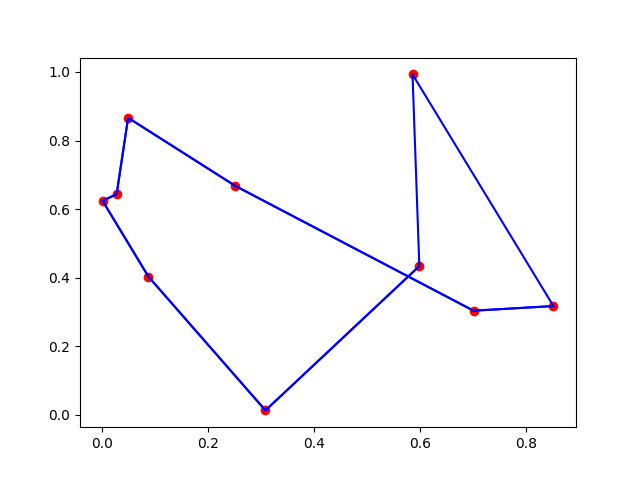

<IPython.core.display.Javascript object>


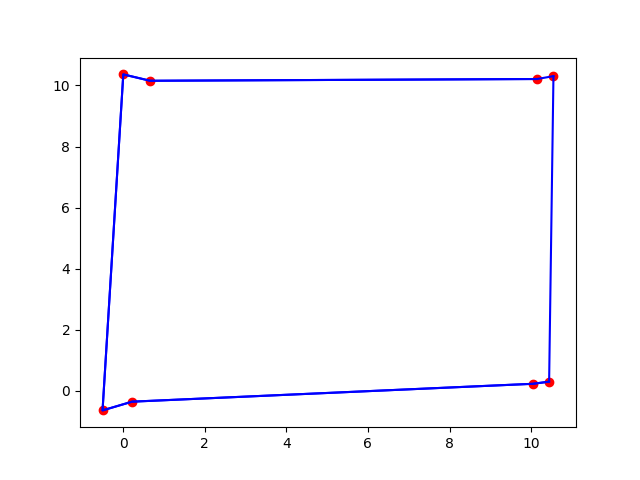

<IPython.core.display.Javascript object>


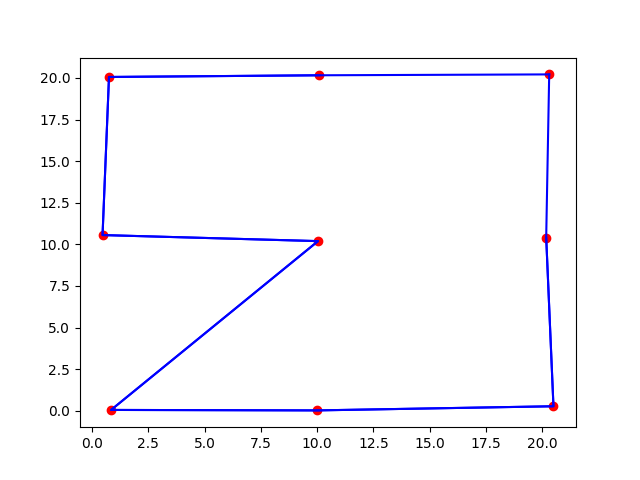

<IPython.core.display.Javascript object>


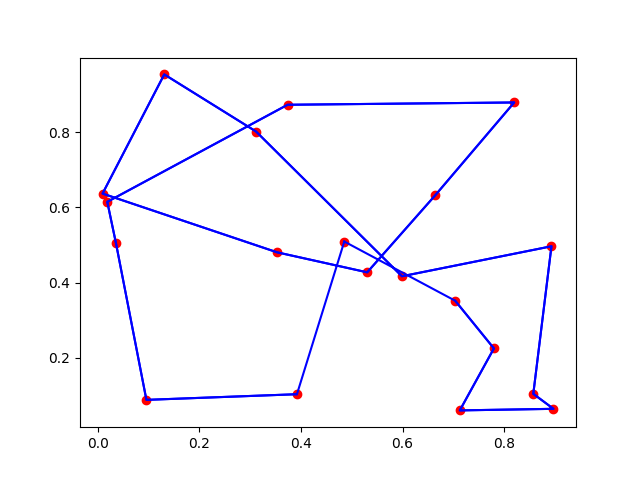

<IPython.core.display.Javascript object>


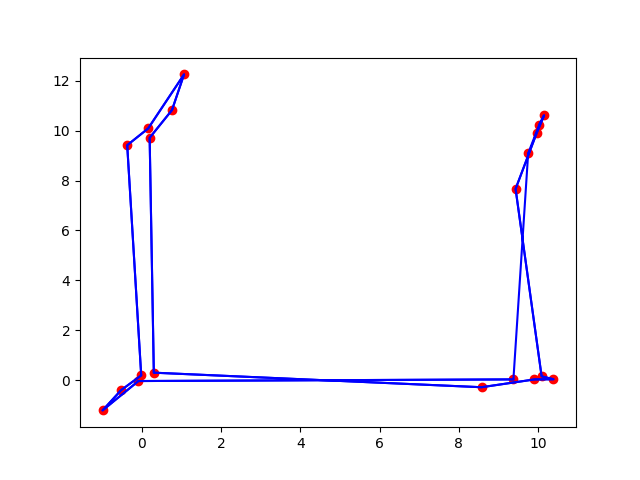

<IPython.core.display.Javascript object>


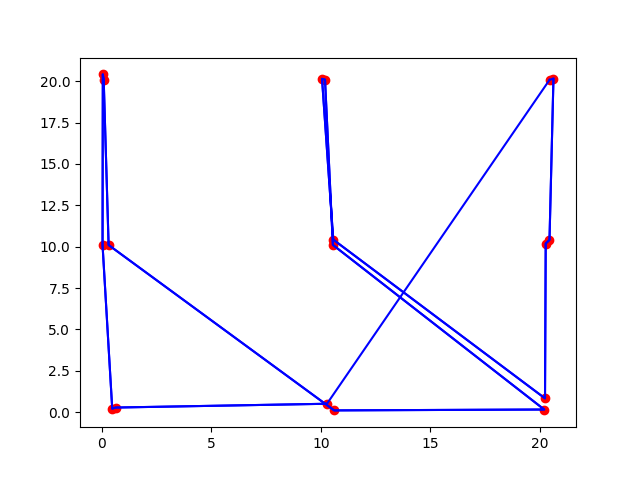

<IPython.core.display.Javascript object>


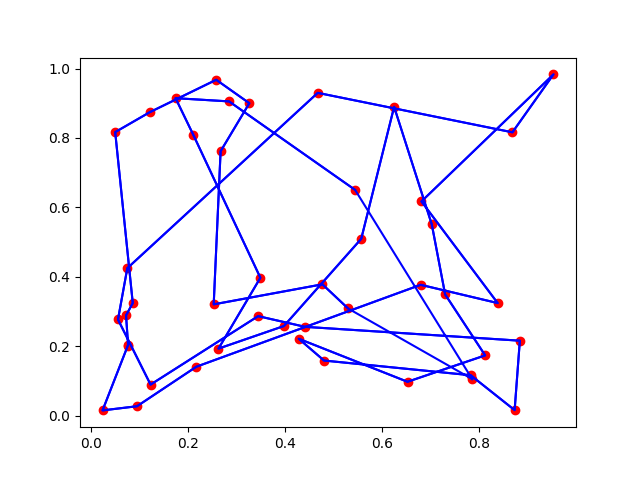

<IPython.core.display.Javascript object>


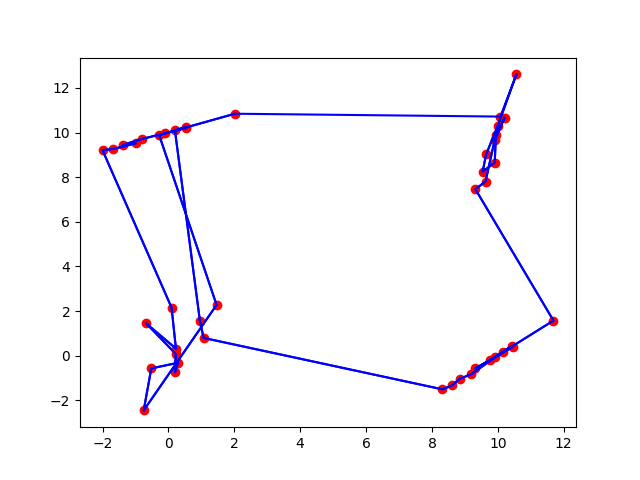

<IPython.core.display.Javascript object>


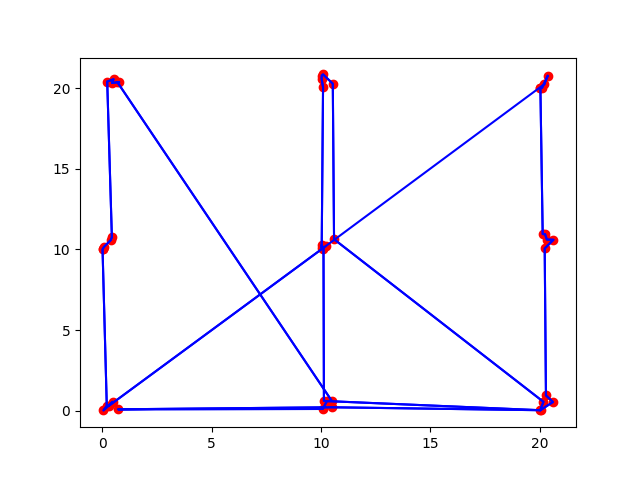

In [19]:
for name in g_plots.keys():
    plot_graph(g_plots[name],name)

# 1.1 b

Now we will check behaviour of annealing with different types of cooling schedules and states generating methods.

<IPython.core.display.Javascript object>


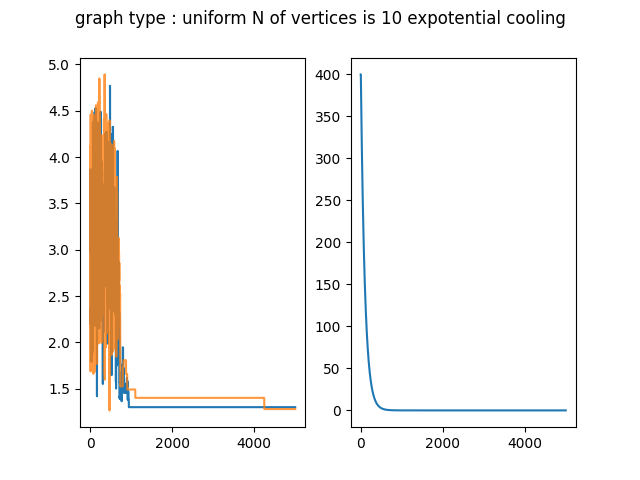

(0, 2)


<IPython.core.display.Javascript object>


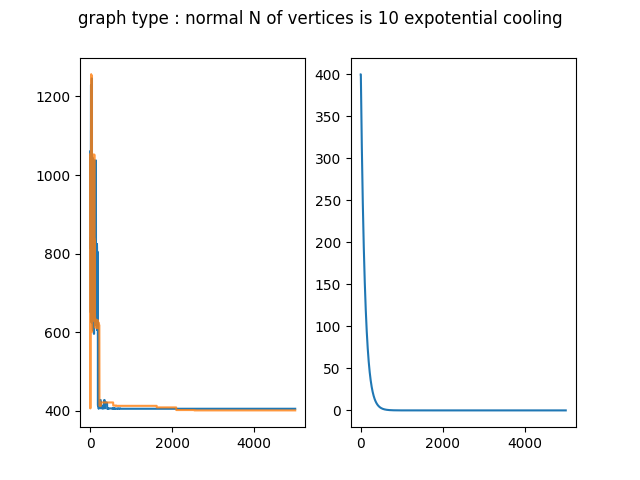

<IPython.core.display.Javascript object>


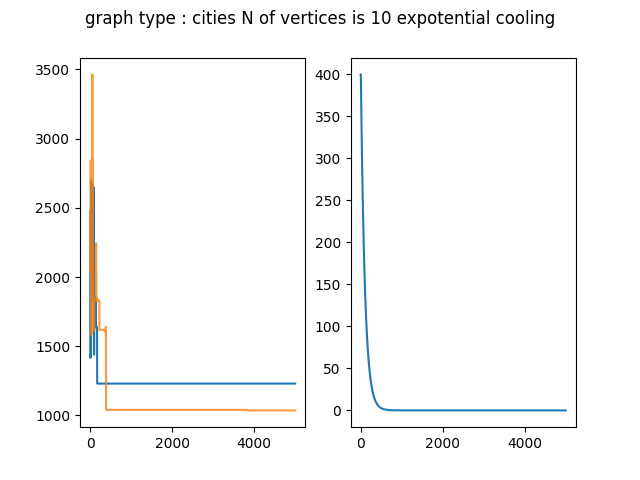

<IPython.core.display.Javascript object>


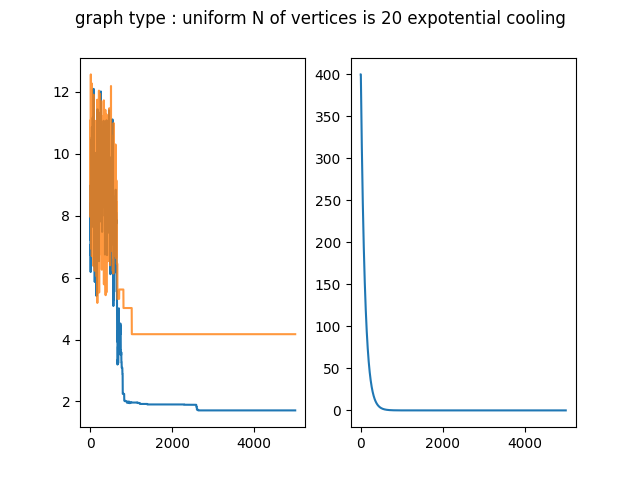

(0, 2)


<IPython.core.display.Javascript object>


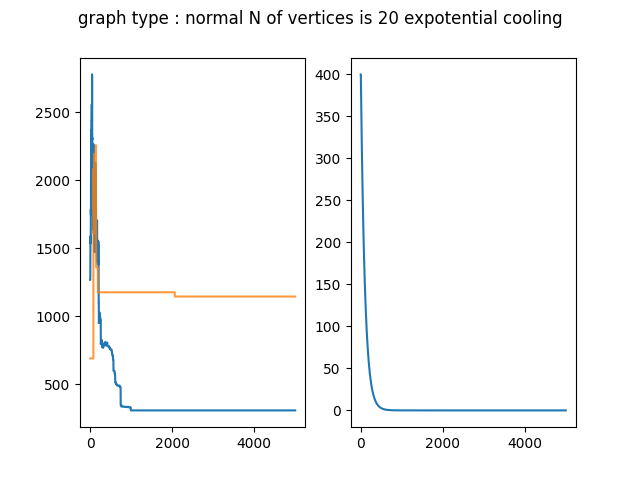

<IPython.core.display.Javascript object>


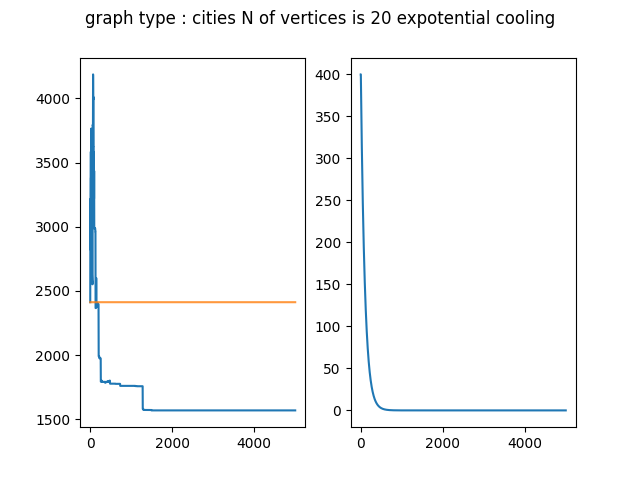

<IPython.core.display.Javascript object>


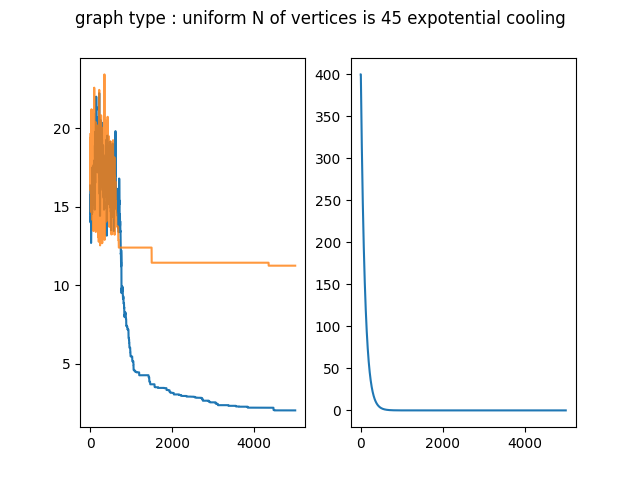

(0, 2)


<IPython.core.display.Javascript object>


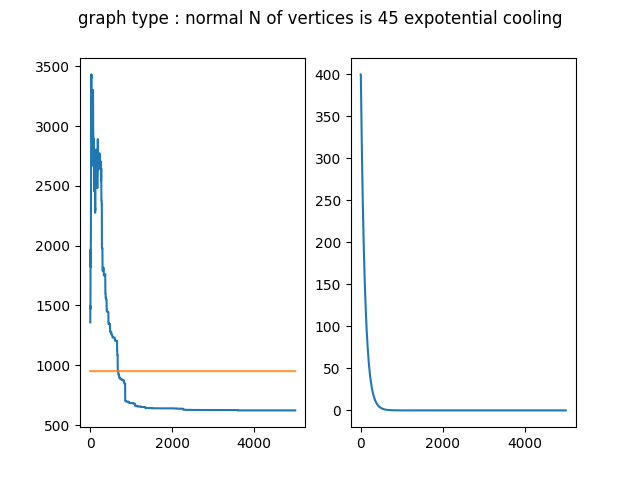

<IPython.core.display.Javascript object>


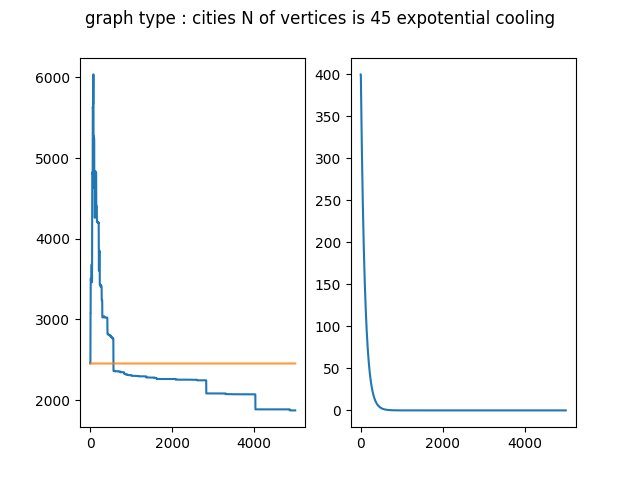

<IPython.core.display.Javascript object>


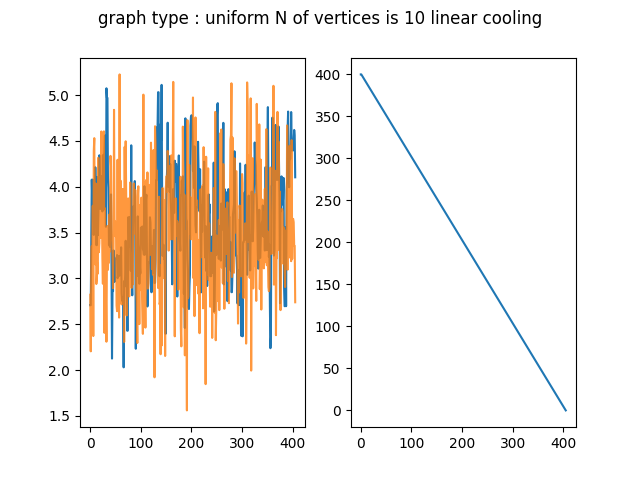

(0, 2)


<IPython.core.display.Javascript object>


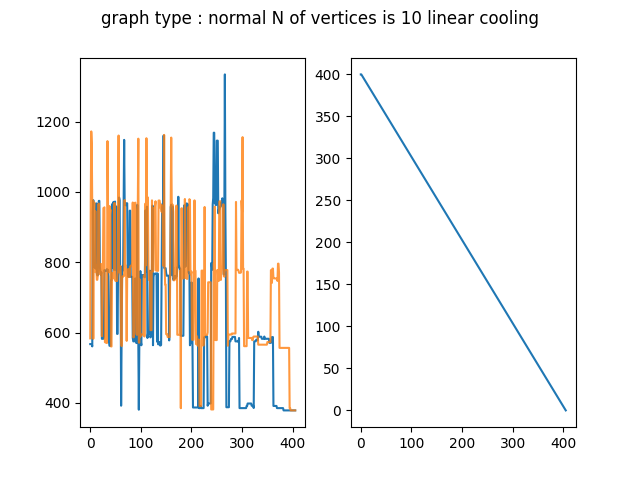

<IPython.core.display.Javascript object>


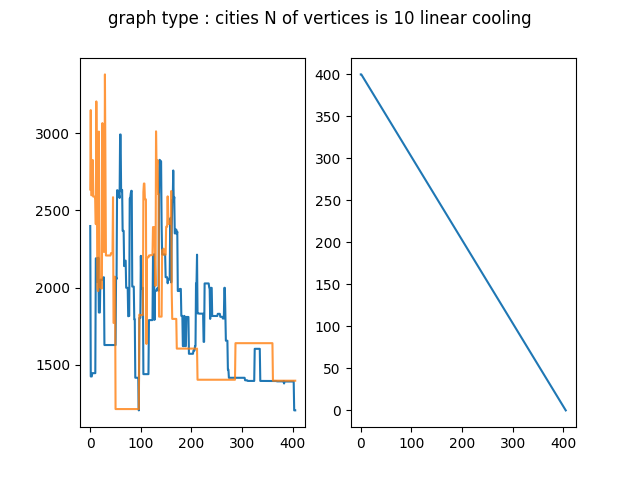

<IPython.core.display.Javascript object>


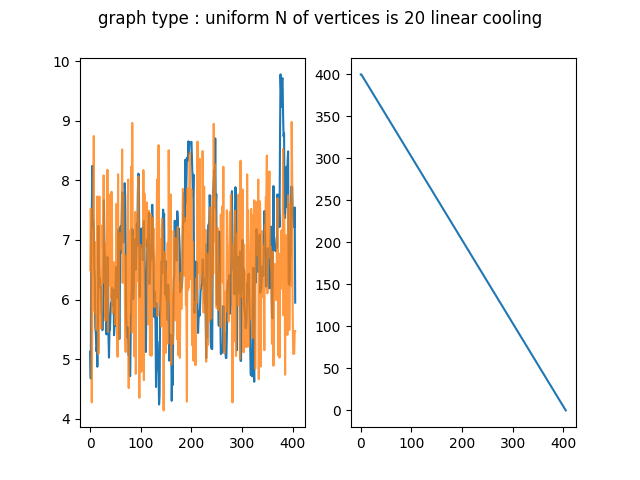

(0, 2)


<IPython.core.display.Javascript object>


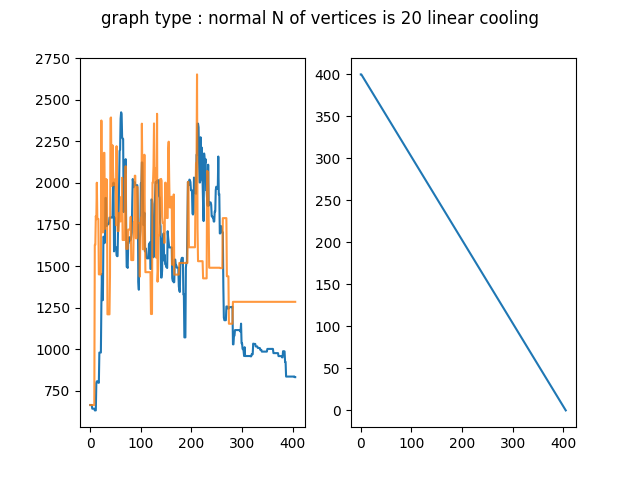

<IPython.core.display.Javascript object>


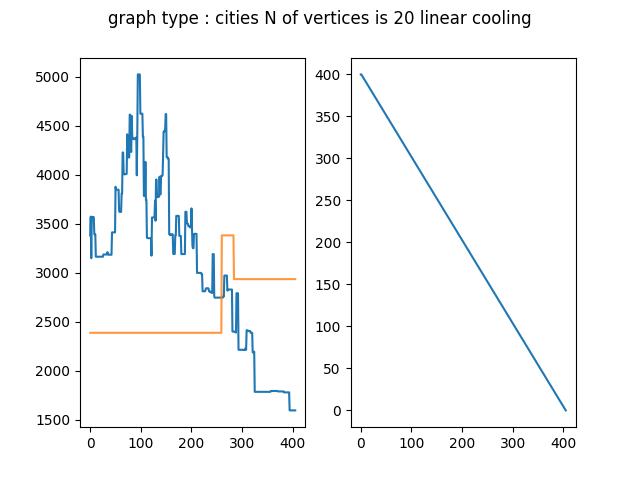

<IPython.core.display.Javascript object>


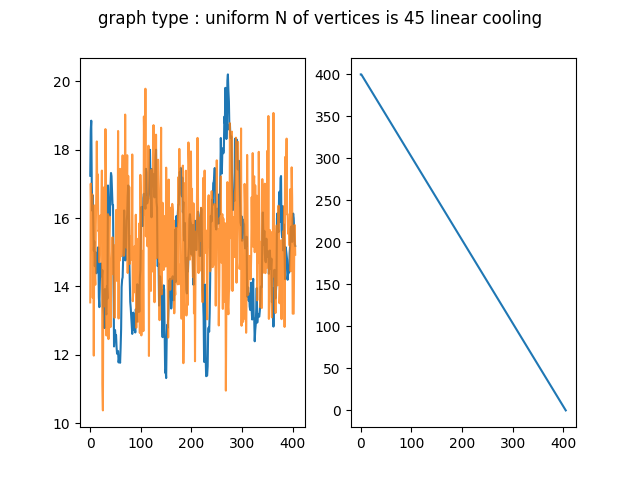

(0, 2)


<IPython.core.display.Javascript object>


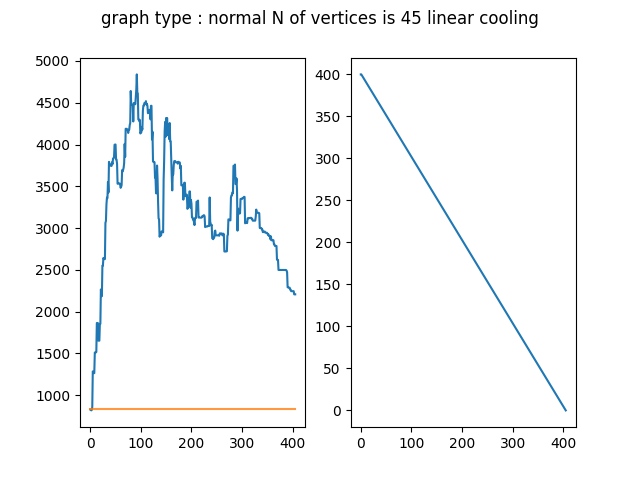

<IPython.core.display.Javascript object>


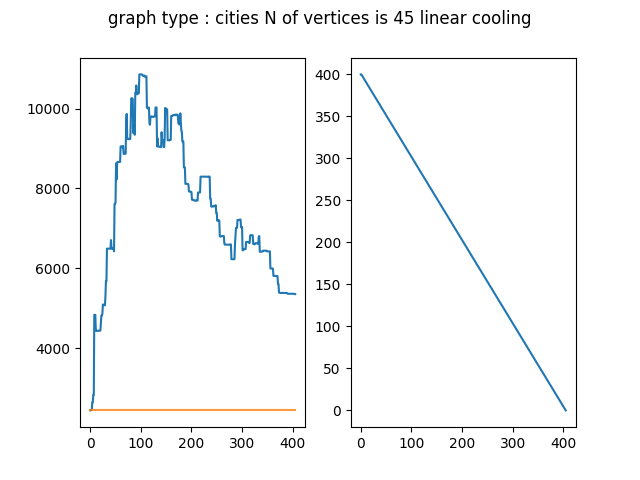

<IPython.core.display.Javascript object>


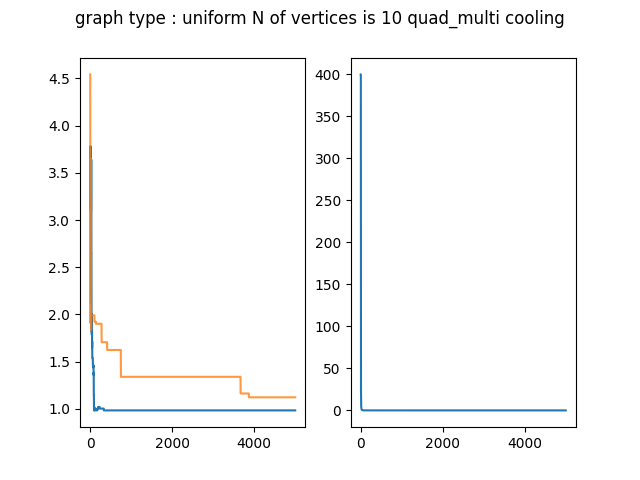

(0, 2)


<ipython-input-104-fa55bc40d3fa>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axes=plt.subplots(nrows=1,ncols=2)


<IPython.core.display.Javascript object>


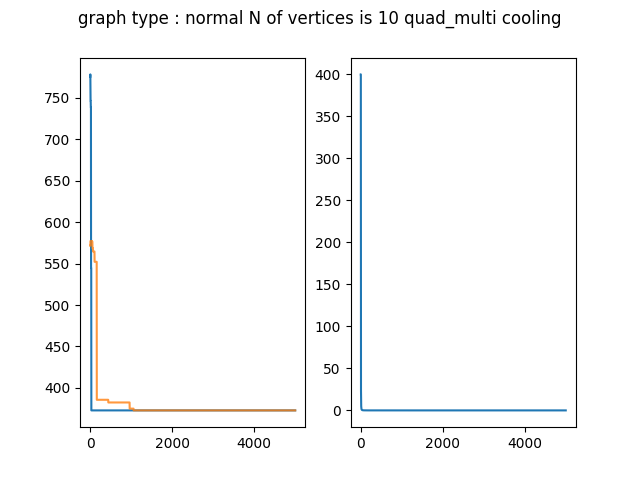

<IPython.core.display.Javascript object>


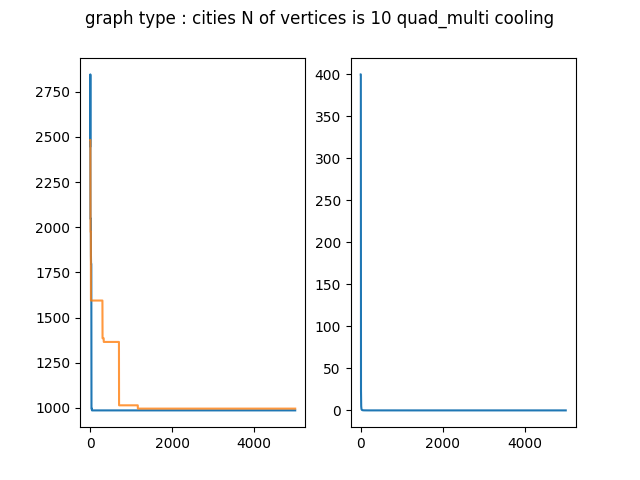

<IPython.core.display.Javascript object>


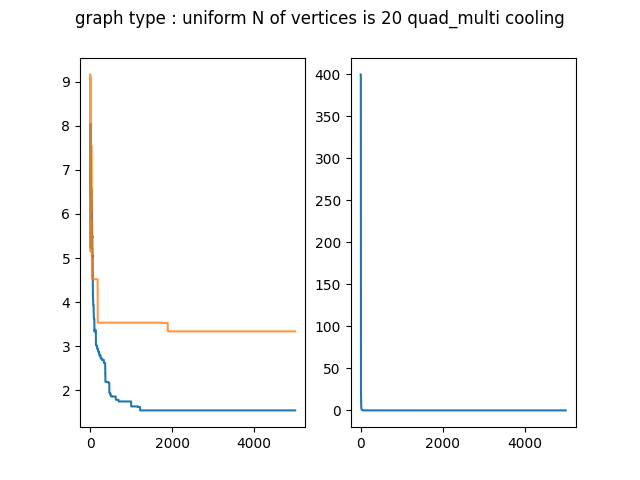

(0, 2)


<IPython.core.display.Javascript object>


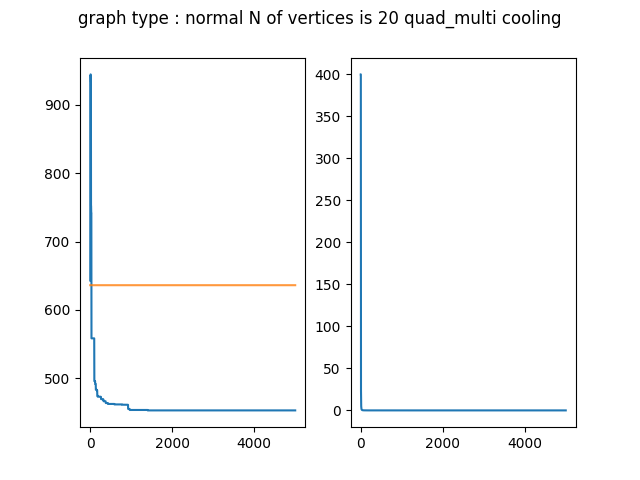

<IPython.core.display.Javascript object>


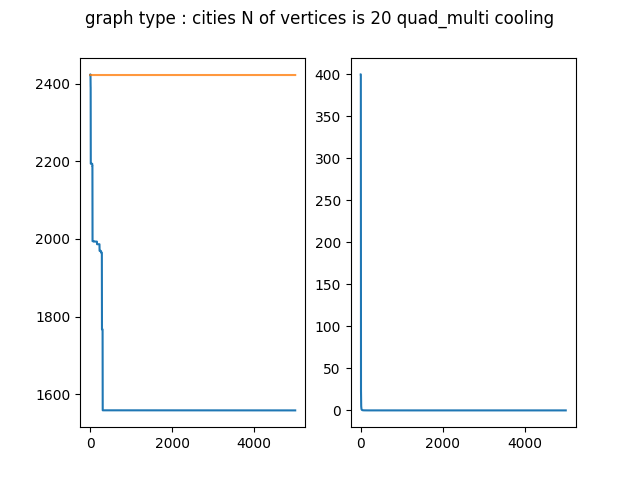

<IPython.core.display.Javascript object>


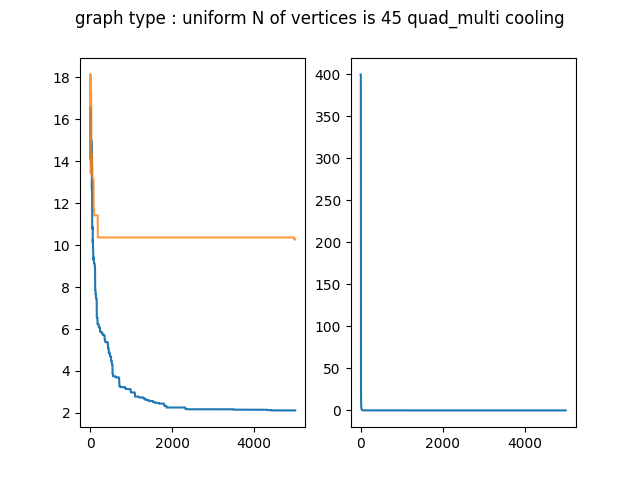

(0, 2)


<IPython.core.display.Javascript object>


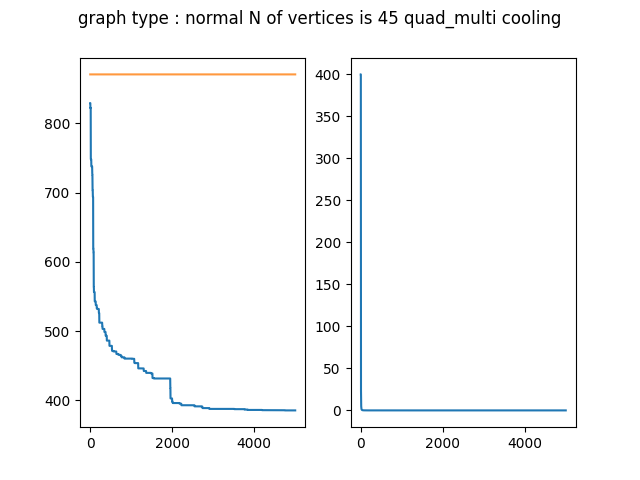

<IPython.core.display.Javascript object>


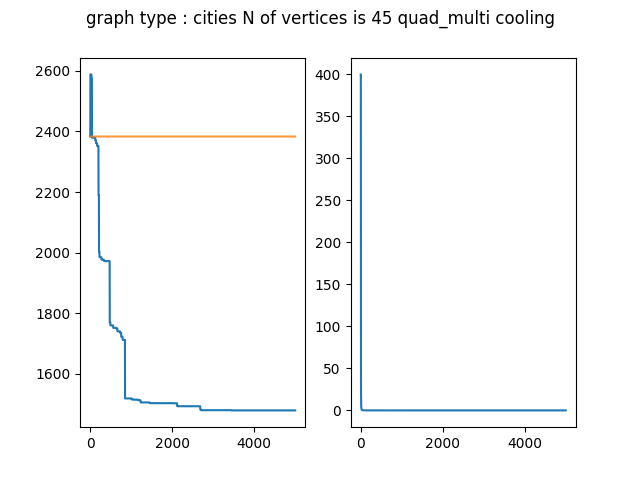

In [115]:

for cooling in ['expotential','linear','quad_multi']:
    for n in [10,20,45]:
        for name in ['uniform','normal','cities']:
            points=gen_points(n,name)
            data=[]
            solve=anneal(max_steps=5000,t_init=400,t_end=0,state_init=points,save_animation=True,
                        neighbour=get_next_state,cost = cost,cooling_type=cooling,swap_type='consecutive',
                        convergance_data=True,conv_data=data)
            data1=[]
            solve1=anneal(max_steps=5000,t_init=400,t_end=0,state_init=points,save_animation=True,
                        neighbour=get_next_state,cost = cost,cooling_type=cooling,swap_type='arbitrary',
                        convergance_data=True,conv_data=data1)
            plot_convergence(data[0][0],data1[0][0],data[0][1],'graph type : '+name+', N of vertices is: '+str(n)+' '+cooling+' cooling')

cooling schedules were taken from here https://nathanrooy.github.io/posts/2020-05-14/simulated-annealing-with-python/

<IPython.core.display.Javascript object>


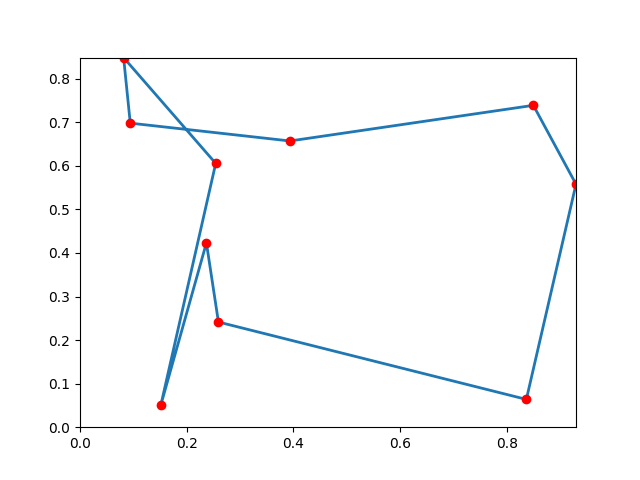

(0, 2)


<IPython.core.display.Javascript object>


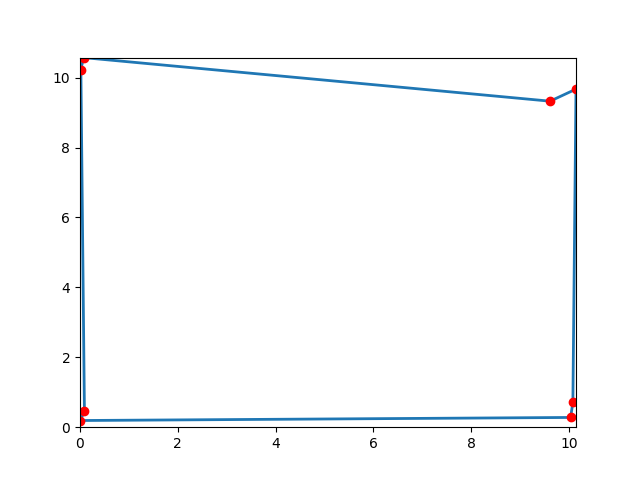

<IPython.core.display.Javascript object>


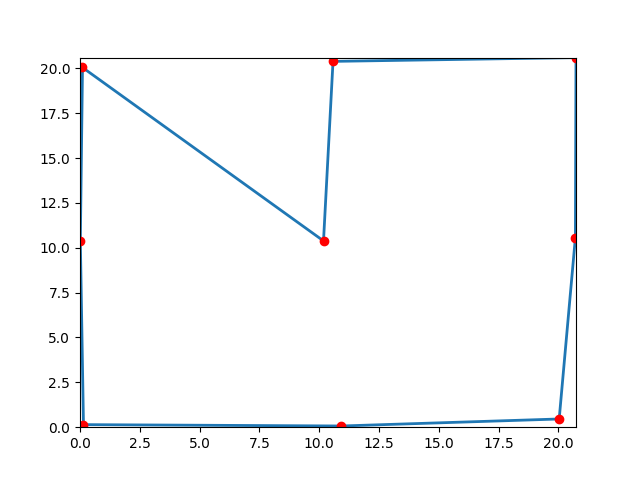

<IPython.core.display.Javascript object>


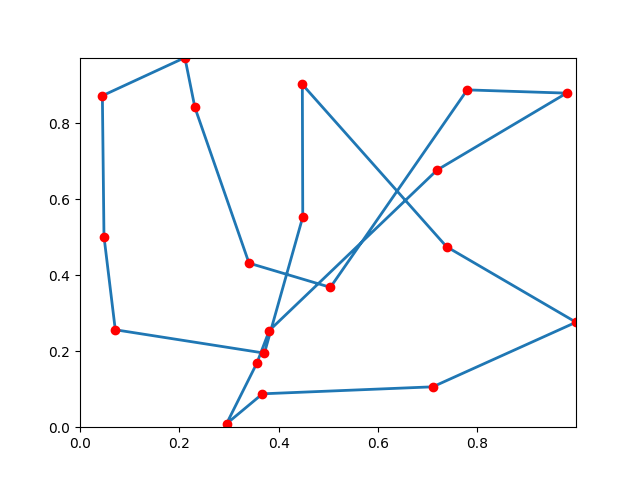

(0, 2)


<IPython.core.display.Javascript object>


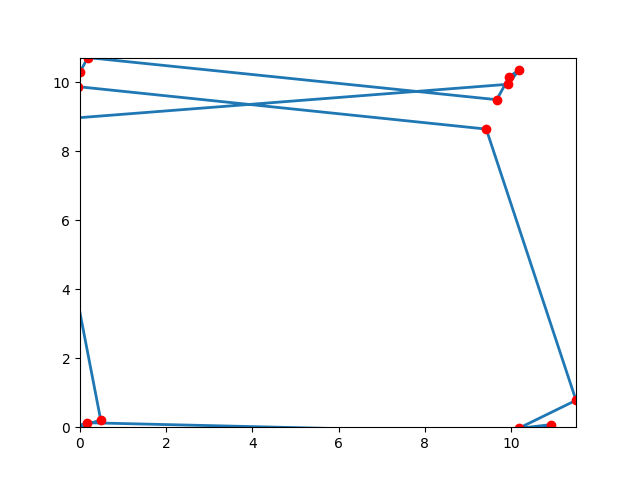

<IPython.core.display.Javascript object>


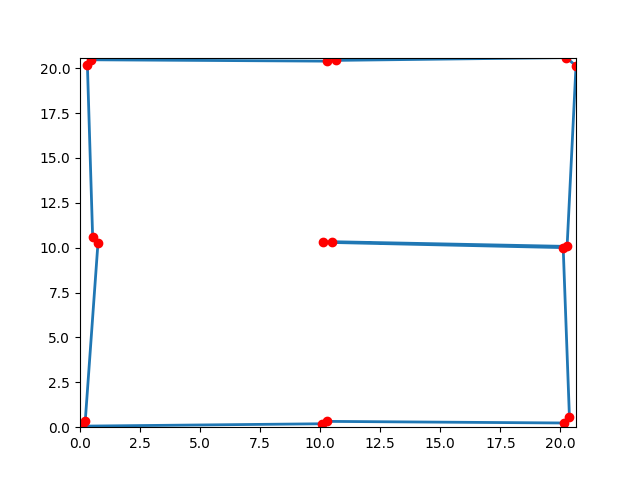

<IPython.core.display.Javascript object>


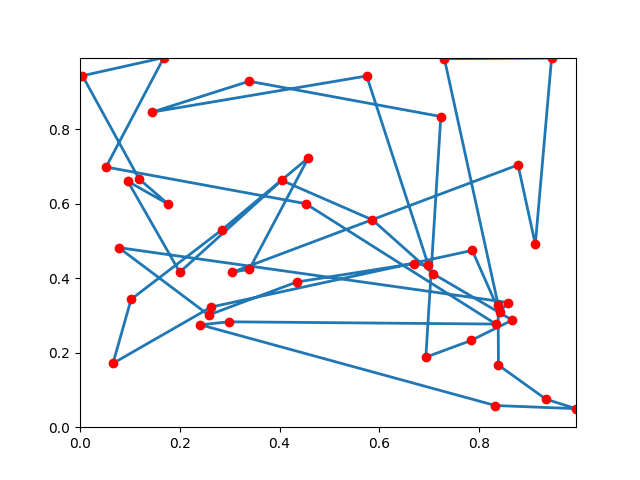

(0, 2)


<IPython.core.display.Javascript object>


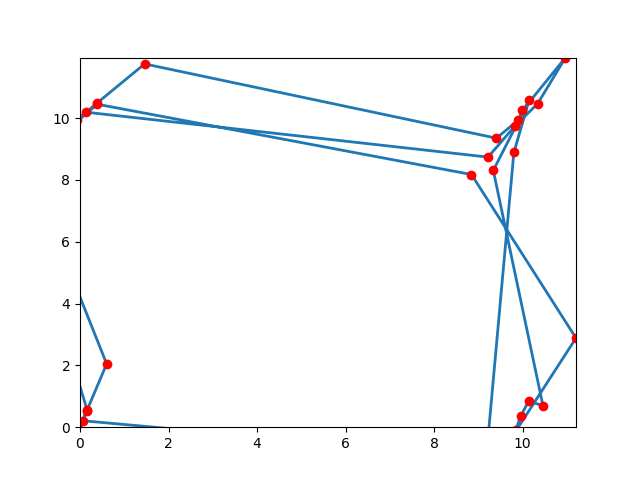

<IPython.core.display.Javascript object>


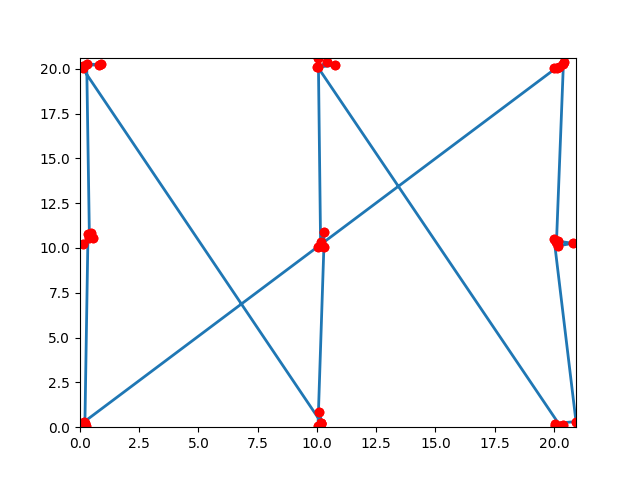

In [119]:
for n in [10,20,45]:
    for name in ['uniform','normal','cities']:
        points=gen_points(n,name)
        data=[]
        solve=anneal(max_steps=1000,t_init=400,t_end=0,state_init=points,save_animation=True,
                      neighbour=get_next_state,cost = cost,cooling_type='expotential',swap_type='consecutive',
                        convergance_data=True,conv_data=data)
        coords_hist=solve[2]
        fig = plt.figure()
        ax = plt.axes(xlim=(0, max([coords_hist[0][i][0] for i in range(len(coords_hist[0]))])), 
                    ylim=(0, max([coords_hist[0][i][1] for i in range(len(coords_hist[0]))])))    
        line, = ax.plot([], [], lw=2)
        def init():
            x = [coords_hist[0][i][0] for i in range(len(coords_hist[0]))]
            y = [coords_hist[0][i][1] for i in range(len(coords_hist[0]))]
            plt.plot(x, y, 'ro')
            line.set_data([], [])
            return line,

        def animate(i):
            x=[[coords_hist[i][k-1][0],coords_hist[i][k][0]] for k in range(1,len(coords_hist[i]))]
            x.append([coords_hist[i][-1][0],coords_hist[i][0][0]])
            y=[[coords_hist[i][k-1][1],coords_hist[i][k][1]] for k in range(1,len(coords_hist[i]))]
            y.append([coords_hist[i][-1][1],coords_hist[i][0][1]])
            line.set_data(x, y)
            return line,
        anim = FuncAnimation(fig, animate, init_func=init,
                                        frames=len(coords_hist), interval=10, blit=True, repeat=False)
        anim.save(name+str(n)+'.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

3. Solving sudoku

In [172]:
def read_sudoku_from_file(file_name):
    """returns sudoku as np.array"""
    with open(file_name,"r") as file:
        lines=file.readlines()
        sudoku=np.zeros((9,9))
        fixed={}
        for i,line in enumerate(lines):
            x=[-1  if line[i]=='x' else int(line[i]) if line[i]!='\n' else 0 for i in range(len(line)-1)]
            for j in range(len(x)):
                if x[j]!=-1:
                    fixed[(i,j)]=x[j]
                sudoku[i,j]=x[j]    
        return sudoku,fixed
def next_sudoku(old_state,options):
#     Choose randomly i and j, such that (a) 1 ≤ i, j ≤ n^2 , and (b) cell i, j is non-fixed.
# Choose randomly k and l, such that (a) cell k, l is in the same square as cell i, j , (b) cell k, l is non-fixed,
# and (c) cell k, l ≠ cell i, j .
# Swap cell i, j with cell k, l .
    state=old_state.copy()
    i,j=np.random.randint(0,state.shape[0],size=2)
    k,l=np.random.randint(0,state.shape[0],size=2)
    state[i][j],state[k][l]=state[k][l],state[i][j]
    return state
def same_val_count(arr):
    res=0
#     rows
    for i in range(arr.shape[0]):
        counts=np.unique(arr[i],return_counts=True)[1]
        res+=np.sum(np.where(counts>1,counts,0))
    for i in range(arr.shape[1]):
        counts=np.unique(arr[:,i],return_counts=True)[1]
        res+=np.sum(np.where(counts>1,counts,0))
    return res
def sudoku_cost(sudoku):
    res=same_val_count(sudoku)
    for i in range(0,9,3):
        for k in range(0,9,3):
            res+=same_val_count(sudoku[i:i+3,k:k+3])
    return res
# fill with random values, such that each value beetwen 1 and n^2 occurs only once 
# in each 3x3 square
# TODO
# end sudoku and tsp
def fix(array):
    c=1
    occupied=[0 for i in range(10)]
    occupied[0]=1
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j]!=-1:
                occupied[int(array[i][j])]=1
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j]==-1:
                for k in range(len(occupied)):
                    if occupied[k]==0:
                        array[i][j]=k
                        occupied[k]=1
                        break
    return array
directory='sudokus'
succes_count=0
for filename in os.listdir(directory):
    print(filename)
    sudoku,fixed=read_sudoku_from_file('sudokus/'+filename)
    for i in range(0,9,3):
        for k in range(0,9,3):
            sudoku[i:i+3,k:k+3]=fix(sudoku[i:i+3,k:k+3].copy())
    x=anneal(max_steps=50000,t_init=40,t_end=0,state_init=sudoku,save_animation=False,
             neighbour=next_sudoku,cost = sudoku_cost,cooling_type='quad_multi',swap_type='consecutive',convergance_data=False)
    print(x[0])
#     print(x[1])
    if x[0]==0:
        succes_count+=1
        np.savetxt(filename+'_solve',x[1])
print('succes_rate is : ',succes_count/97*100)

sudoku66
0
sudoku30
0
sudoku82
0
sudoku86
0
sudoku72
0
sudoku29
0
sudoku69
0
sudoku23
0
sudoku27
0
sudoku16
0
sudoku44
0
sudoku75
0
sudoku91
0
sudoku14
0
sudoku35
0
sudoku83
0
sudoku79
0
sudoku2
0
sudoku85
0
sudoku13
0
sudoku45
0
sudoku93
0
sudoku33
0
sudoku50
0
sudoku78
0
sudoku68
0
sudoku62
0
sudoku94
0
sudoku70
0
sudoku64
0
sudoku84
0
sudoku88
0
sudoku76
0
sudoku19
0
sudoku58
0
sudoku1
0
sudoku40
0
sudoku42
0
sudoku8
0
sudoku52
0
sudoku36
0
sudoku92
0
sudoku96
0
sudoku65
0
sudoku81
0
sudoku80
0
sudoku6
0
sudoku57
0
sudoku22
4
sudoku73
0
sudoku41
4
sudoku46
0
sudoku25
0
sudoku87
0
sudoku51
0
sudoku12
0
sudoku15
0
sudoku67
0
sudoku3
0
sudoku37
0
sudoku18
0
sudoku53
0
sudoku31
0
sudoku77
0
sudoku90
0
sudoku11
0
sudoku28
0
sudoku47
0
sudoku17
0
sudoku9
0
sudoku63
0
sudoku5
0
sudoku89
0
sudoku0
0
sudoku55
0
sudoku71
4
sudoku10
0
sudoku34
0
sudoku4
0
sudoku60
0
sudoku38
0
sudoku49
0
sudoku26
0
sudoku61
0
sudoku48
0
sudoku54
0
sudoku7
0
sudoku56
0
sudoku39
0
sudoku24
0
sudoku95
0
sudoku21


In [166]:
print(x[0],x[1])
print('###')
print(sudoku_cost(x[2][-1]))

0 [[4. 2. 3. 5. 6. 7. 1. 9. 8.]
 [8. 7. 4. 2. 1. 9. 5. 3. 6.]
 [7. 1. 5. 6. 8. 3. 9. 4. 2.]
 [6. 3. 8. 1. 9. 2. 4. 5. 7.]
 [1. 5. 6. 3. 4. 8. 7. 2. 9.]
 [9. 8. 1. 7. 3. 5. 2. 6. 4.]
 [5. 6. 9. 8. 2. 4. 3. 7. 1.]
 [3. 4. 2. 9. 7. 1. 6. 8. 5.]
 [2. 9. 7. 4. 5. 6. 8. 1. 3.]]
###


IndexError: invalid index to scalar variable.